In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.regression import *

#from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    silhouette_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    explained_variance_score,
    PredictionErrorDisplay,
)

from IPython.display import display
from IPython.core.display import HTML

import warnings

warnings.filterwarnings("ignore")

display(HTML("<style = font-size>pre {white-space: pre !important;}</style>"))

data_dir = "./data"

In [2]:
def Kmeans_cluster(data, k):
    # 2. initialize the model
    my_kmeans = KMeans(n_clusters=k)

    # 3. fit the model to the data
    my_kmeans.fit(data)  # pass your scaled data here

    # 4. obtain the cluster output
    clusters = my_kmeans.predict(data)  # pass your scaled data here
    centroids = my_kmeans.cluster_centers_

    return clusters, pd.DataFrame(centroids)
    # 5. attach the cluster output to our original DataFrame

In [3]:
def clusters_num(data):
    inertia_list = []
    k = []
    sil_score = []
    for i in range(2, 30):
        k.append(i)
        myKMeans = KMeans(n_clusters=i)
        myKMeans.fit(data)
        inertia_list.append(round(myKMeans.inertia_, 2))
        sil_score.append(round(silhouette_score(data, myKMeans.labels_), 2))
    return inertia_list, sil_score, k

In [4]:
def scaler(scaler, data: pd.DataFrame, columns: list = None):
	if columns is None:
		columns = data.columns

	for column in columns:
		data[column] = pd.DataFrame(scaler.fit_transform(data[[column]]))	

	return data

In [5]:
df_insurance = pd.read_csv(f"{data_dir}/insurance.csv")
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# Data Cleaning
df_insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
# Feature Engeneering
df_insurance["born_year"] = (pd.Timestamp.now() - (df_insurance["age"] * np.timedelta64(365, "D"))).dt.year
df_insurance["has_children"] = df_insurance["children"] > 0
df_insurance = pd.get_dummies(df_insurance, drop_first=True)

df_insurance

,age,bmi,children,charges,born_year,has_children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,2005,False,False,True,False,False,True
1,18,33.770,1,1725.55230,2006,True,True,False,False,True,False
2,28,33.000,3,4449.46200,1996,True,True,False,False,True,False
3,33,22.705,0,21984.47061,1991,False,True,False,True,False,False
4,32,28.880,0,3866.85520,1992,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1974,True,True,False,True,False,False
1334,18,31.920,0,2205.98080,2006,False,False,False,False,False,False
1335,18,36.850,0,1629.83350,2006,False,False,False,False,True,False
1336,21,25.800,0,2007.94500,2003,False,False,False,False,False,True


In [8]:
# Data Analysis
df_insurance.describe()

,age,bmi,children,charges,born_year
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,1984.792975
std,14.049960,6.098187,1.205493,12110.011237,14.049960
min,18.000000,15.960000,0.000000,1121.873900,1960.000000
25%,27.000000,26.296250,0.000000,4740.287150,1973.000000
50%,39.000000,30.400000,1.000000,9382.033000,1985.000000
75%,51.000000,34.693750,2.000000,16639.912515,1997.000000
max,64.000000,53.130000,5.000000,63770.428010,2006.000000


In [9]:
# Data Transformation

## <<< A aplicação da técnica de Standarização diminui a acurácia neste modelo >>> 
# data_scaled = scaler(MinMaxScaler(), df_insurance.copy(), columns=['age', 'bmi', 'children', 'charges', 'born_year']) 
data_scaled = df_insurance.copy()

In [10]:
clusters, centroids = Kmeans_cluster(data_scaled, 4)

In [11]:
df_insurance["cluster"] = clusters
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   born_year         1338 non-null   int32  
 5   has_children      1338 non-null   bool   
 6   sex_male          1338 non-null   bool   
 7   smoker_yes        1338 non-null   bool   
 8   region_northwest  1338 non-null   bool   
 9   region_southeast  1338 non-null   bool   
 10  region_southwest  1338 non-null   bool   
 11  cluster           1338 non-null   int32  
dtypes: bool(6), float64(2), int32(2), int64(2)
memory usage: 60.2 KB


In [12]:
df_insurance

,age,bmi,children,charges,born_year,has_children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,cluster
0,19,27.900,0,16884.92400,2005,False,False,True,False,False,True,3
1,18,33.770,1,1725.55230,2006,True,True,False,False,True,False,0
2,28,33.000,3,4449.46200,1996,True,True,False,False,True,False,0
3,33,22.705,0,21984.47061,1991,False,True,False,True,False,False,2
4,32,28.880,0,3866.85520,1992,False,True,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1974,True,True,False,True,False,False,3
1334,18,31.920,0,2205.98080,2006,False,False,False,False,False,False,0
1335,18,36.850,0,1629.83350,2006,False,False,False,False,True,False,0
1336,21,25.800,0,2007.94500,2003,False,False,False,False,False,True,0


In [13]:
df_insurance["cluster"] = df_insurance["cluster"].astype("category")
df_insurance = pd.get_dummies(df_insurance, drop_first=True)
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   born_year         1338 non-null   int32  
 5   has_children      1338 non-null   bool   
 6   sex_male          1338 non-null   bool   
 7   smoker_yes        1338 non-null   bool   
 8   region_northwest  1338 non-null   bool   
 9   region_southeast  1338 non-null   bool   
 10  region_southwest  1338 non-null   bool   
 11  cluster_1         1338 non-null   bool   
 12  cluster_2         1338 non-null   bool   
 13  cluster_3         1338 non-null   bool   
dtypes: bool(9), float64(2), int32(1), int64(2)
memory usage: 58.9 KB


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>],
       [<Axes: title={'center': 'born_year'}>, <Axes: >]], dtype=object)

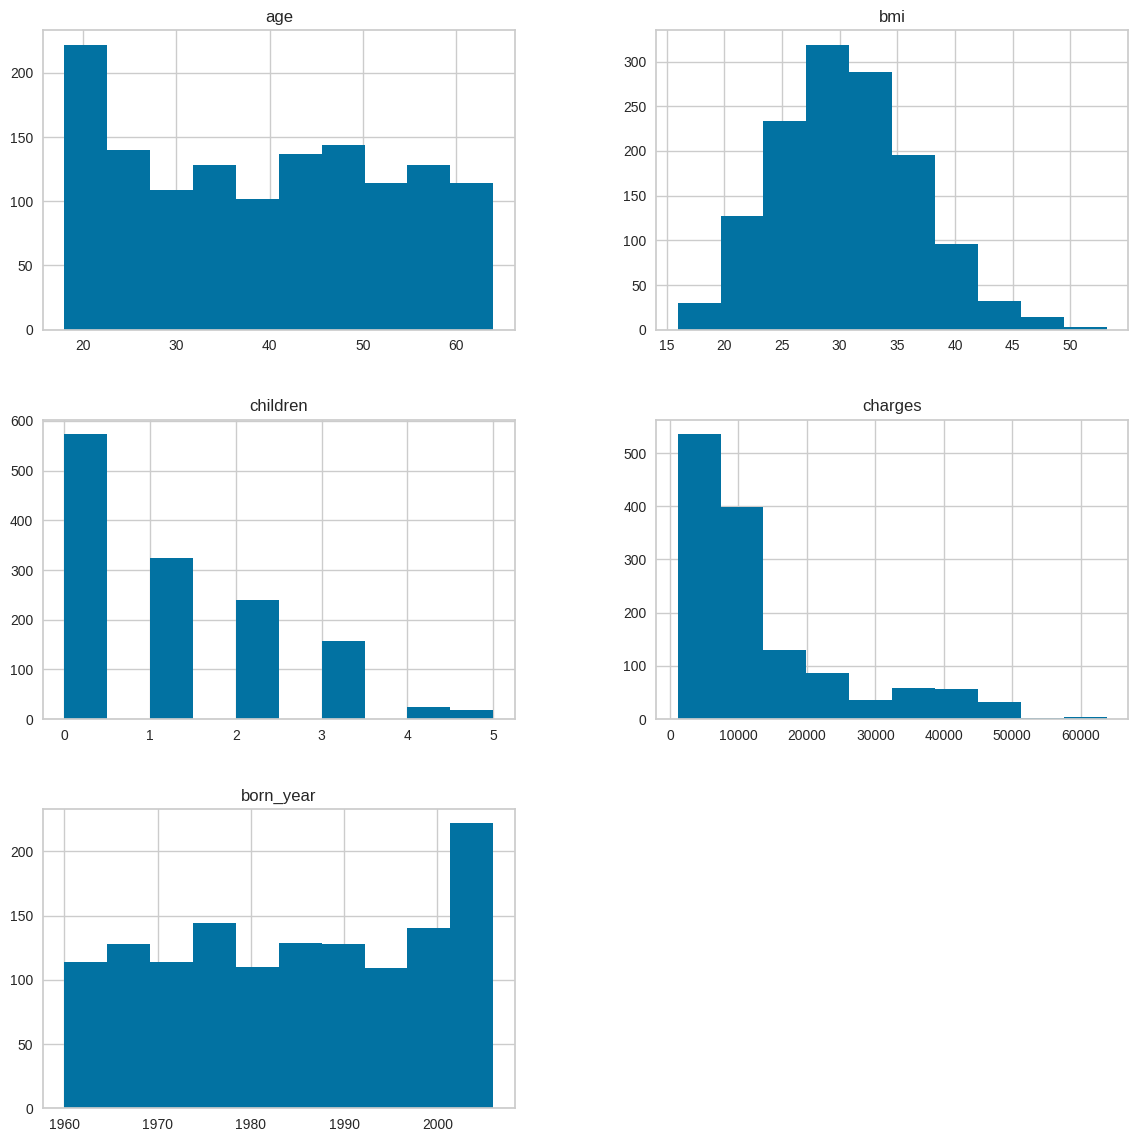

In [14]:
df_insurance.hist(figsize=(14, 14))

<Axes: >

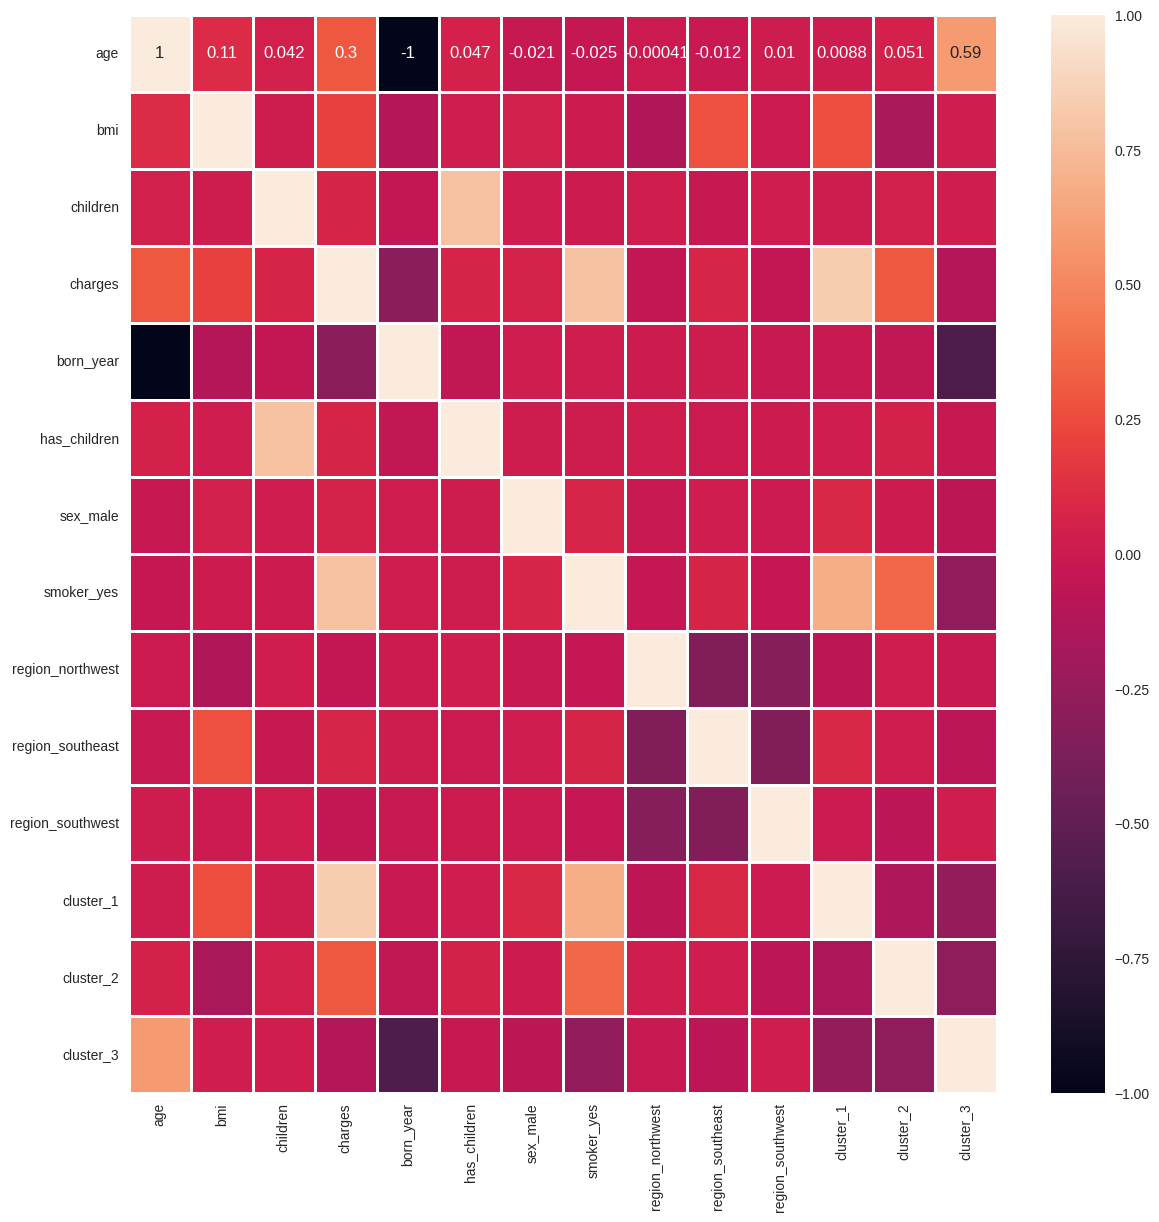

In [15]:
# Data Analysis
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df_insurance.corr(), annot=True, linewidths=0.8)

In [16]:
train_data, validation_data = train_test_split(
    df_insurance, train_size=0.8, random_state=123, shuffle=True
)

In [17]:
train_data.shape

(1070, 14)

In [18]:
validation_data.shape

(268, 14)

In [ ]:
experiment = RegressionExperiment()
experiment.setup(
    data=train_data, train_size=0.9, target="charges", session_id=123, use_gpu=True
)

In [20]:
best_model = experiment.compare_models()#exclude=["lightgbm", "gbr"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,8946.9185,141001691.2853,11824.2130,-0.0053,1.0002,1.5289,0.0170
omp,Orthogonal Matching Pursuit,8944.4340,140946279.1255,11823.9254,-0.0055,0.9992,1.5241,0.0080
dummy,Dummy Regressor,8942.3224,141177483.2000,11834.2587,-0.0074,1.0009,1.5293,0.0080
br,Bayesian Ridge,8950.4776,141190531.8669,11834.9779,-0.0075,1.0006,1.5277,0.0120
ridge,Ridge Regression,8998.6123,141594914.3651,11847.4954,-0.0091,1.0011,1.5314,0.0110
lasso,Lasso Regression,8998.8723,141602672.8711,11847.8316,-0.0092,1.0011,1.5315,0.0120
llar,Lasso Least Angle Regression,8998.8682,141602656.2056,11847.8308,-0.0092,1.0011,1.5315,0.0090
lar,Least Angle Regression,8968.4304,142000572.1473,11863.9658,-0.0118,0.9984,1.5163,0.0100
lr,Linear Regression,9015.5110,143291489.3063,11906.7566,-0.0181,1.0031,1.5219,0.0100
huber,Huber Regressor,8279.8903,151614610.2648,12254.9211,-0.0794,0.9281,1.1025,0.0310


In [21]:
experiment.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [22]:
predict_holdout = experiment.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9930.7665,183189310.3676,13534.7446,-0.0141,1.0497,1.5947


In [23]:
tuned_model = experiment.tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7830.7124,99168837.3233,9958.3552,0.0208,0.8752,1.2180
1,7986.9328,114650786.0814,10707.5107,0.0163,0.9422,1.3763
2,8988.1088,140674285.1227,11860.6191,0.0128,0.9711,1.4348
3,10184.4031,200344967.2009,14154.3268,-0.0284,0.9904,1.3875
4,8275.9861,121735735.4297,11033.3918,-0.0399,1.0558,1.7574
5,8892.7356,149540583.4296,12228.6787,0.0012,1.0228,1.5784
6,9173.6505,148147749.5180,12171.5960,0.0018,1.0761,1.7788
7,9626.2672,160175085.3665,12656.0296,-0.0069,0.9652,1.3785
8,9407.5351,143962796.1621,11998.4497,-0.0106,1.0900,1.8173


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [24]:
tuned_model = experiment.finalize_model(tuned_model)

In [25]:
X_test = validation_data.copy().drop("charges", axis=1)
predictions = experiment.predict_model(tuned_model, data=X_test)

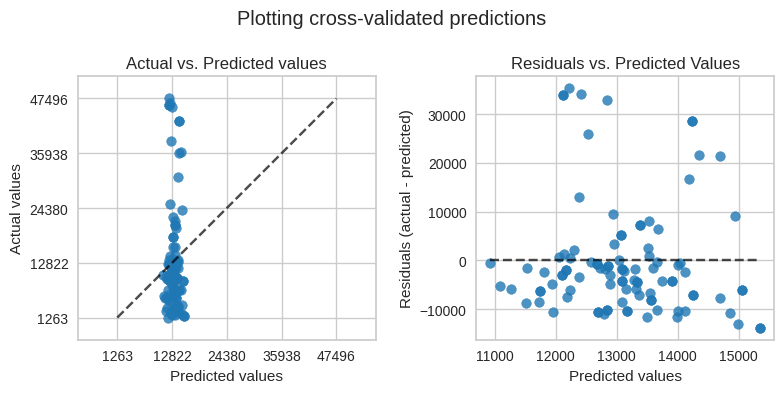

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    validation_data["charges"],
    y_pred=predictions["prediction_label"],
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    validation_data["charges"],
    y_pred=predictions["prediction_label"],
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

In [27]:
print(
    "MSE: ",
    mean_squared_error(
        validation_data["charges"].values, predictions["prediction_label"].values
    ),
)
print(
    "MAE",
    mean_absolute_error(
        validation_data["charges"].values, predictions["prediction_label"].values
    ),
)
print(
    "MedianAE",
    median_absolute_error(
        validation_data["charges"].values, predictions["prediction_label"].values
    ),
)
print(
    "Explained Variance: ",
    explained_variance_score(
        validation_data["charges"].values, predictions["prediction_label"].values
    ),
)
print(
    "R2: ",
    r2_score(validation_data["charges"].values, predictions["prediction_label"].values),
)

MSE:  152901000.72602522
MAE 9051.093069093713
MedianAE 7172.265324295211
Explained Variance:  0.0010693308907494536
R2:  -3.565434336394446e-05
